<h1> 95% Consistency Analysis with Raw MBA Data </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

In [1]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [40]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from google.cloud import bigquery
import warnings




os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h3> SQL Queries

<h4> Validated dataset 2020 sql query

In [8]:
peak_download_val2020 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE)) 
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
peak_download_val2020 = client.query(peak_download_val2020).to_dataframe()
print("executed")
print("validated dataset from Sep-Oct 2020")


executed
validated dataset from Sep-Oct 2020


<h4> Raw dataset December 2020 sql query

In [9]:
raw_download_dec2020 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmtDec20` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmtDec20` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
raw_download_dec2020 = client.query(raw_download_dec2020).to_dataframe()
print("executed")
print("raw dataset from Dec 2020")


executed
raw dataset from Dec 2020


<h4> Raw dataset April 2021 sql query


In [7]:
raw_download_apr2021 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmtApr21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmtApr21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.bytes_sec > 0
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
raw_download_apr2021 = client.query(raw_download_apr2021).to_dataframe()
print("executed")
print("raw dataset from Apr 2021")


executed
raw dataset from Apr 2021


In [18]:
peak_download_val2020.head()

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes,download_service_tier_1,ISP_1,tech_1,_80_80_
0,1.5,CenturyLink,DSL,1.209852,1.235936,0.662552,1.493808,1.062544,1.934584,0.022072,0.259495,65,1.5,CenturyLink,DSL,0.938294
1,3.0,CenturyLink,DSL,2.850427,2.827840,1.484872,4.765216,2.205512,5.404400,0.016840,0.898549,50,3.0,CenturyLink,DSL,2.053360
2,5.0,Cincinnati Bell,DSL,3.696203,4.214408,1.237952,4.327232,3.171976,4.814376,0.249400,1.016765,49,5.0,Cincinnati Bell,DSL,2.999680
3,6.0,Frontier,DSL,5.430807,5.683632,1.655800,7.893608,4.337272,9.551024,0.443104,1.736311,36,6.0,Frontier,DSL,1.499600
4,10.0,CenturyLink,DSL,9.118604,9.617656,6.157064,11.399624,7.968480,12.762944,0.000024,1.662674,71,10.0,CenturyLink,DSL,7.388600


In [19]:
raw_download_dec2020.head()

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes,download_service_tier_1,ISP_1,tech_1,_80_80_
0,1.5,CenturyLink,DSL,2.185146,1.313912,0.710592,1.852456,1.109464,59.770312,0.083320,6.113509,52,1.5,CenturyLink,DSL,0.946632
1,3.0,CenturyLink,DSL,4.025101,2.864192,1.424544,5.201800,2.393248,100.784632,0.029264,9.093956,38,3.0,CenturyLink,DSL,2.107491
2,5.0,Cincinnati Bell,DSL,6.265817,4.230016,1.453592,44.654504,2.616672,60.675280,0.106360,10.372150,39,5.0,Cincinnati Bell,DSL,2.275595
3,10.0,CenturyLink,DSL,9.316201,9.694240,6.047872,11.276984,8.500304,12.636352,0.096048,1.528838,60,10.0,CenturyLink,DSL,7.974059
4,10.0,Windstream,DSL,9.777558,10.104712,5.552904,13.667152,8.200968,120.181088,1.032312,4.711431,43,10.0,Windstream,DSL,6.520909


In [20]:
raw_download_apr2021.head()

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes,download_service_tier_1,ISP_1,tech_1,_80_80_
0,1.5,CenturyLink,DSL,4.696418,1.273992,0.654728,20.352464,1.109464,296.395312,0.009128,17.436646,47,1.5,CenturyLink,DSL,0.848008
1,3.0,CenturyLink,DSL,5.227975,2.973096,0.713208,11.721416,2.494000,104.926184,0.002232,10.265174,35,3.0,CenturyLink,DSL,2.287747
2,5.0,Cincinnati Bell,DSL,8.483106,4.263568,1.637936,46.725728,3.309392,93.942504,0.273952,15.276656,43,5.0,Cincinnati Bell,DSL,2.511659
3,10.0,CenturyLink,DSL,10.377500,9.657304,4.794456,12.135952,7.764000,93.935064,0.000024,8.536036,58,10.0,CenturyLink,DSL,6.816192
4,10.0,Windstream,DSL,12.400658,10.418704,4.879184,16.857528,8.086912,120.184520,0.864776,17.392394,47,10.0,Windstream,DSL,6.633304


In [21]:
# finding non-matches between dec table and validated sep/oct table
df_non_match = pd.merge(peak_download_val2020, raw_download_dec2020, how='outer',indicator=True, on = ['download_service_tier', 'ISP'])
df_non_match = df_non_match[(df_non_match._merge != 'both')]
dropList = df_non_match.index.tolist() 


In [22]:
# finding non-matches between apr table and validated sep/oct table
df_non_match2 = pd.merge(peak_download_val2020, raw_download_apr2021, how='outer',indicator=True, on = ['download_service_tier', 'ISP'])
df_non_match2 = df_non_match2[(df_non_match2._merge != 'both')]
dropList2 = df_non_match2.index.tolist() 

In [23]:
# finding non-matches between dec table and apr table
df_non_match3 = pd.merge(raw_download_dec2020, raw_download_apr2021, how='outer',indicator=True, on = ['download_service_tier', 'ISP'])
df_non_match3 = df_non_match3[(df_non_match3._merge != 'both')]
dropList3 = df_non_match3.index.tolist() 

In [24]:
finalDropList = dropList + dropList2 + dropList3
finalDropList = np.array(finalDropList)
finalDropList = np.unique(finalDropList)
finalDropList = list(finalDropList)

In [25]:
def dfNormalizerD(df):
    
    temp = df['download_service_tier'].astype(int)
    ispTech =  temp.astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']       
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['download_service_tier']
    total_boxes = df['total_boxes']

    isp = df['ISP']
    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty, total_boxes=total_boxes))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result

In [26]:
# cleaning dfs
peak_download_val2020 = dfNormalizerD(peak_download_val2020)
raw_download_dec2020 = dfNormalizerD(raw_download_dec2020)
raw_download_apr2021 = dfNormalizerD(raw_download_apr2021)


In [27]:
finalDF = peak_download_val2020.merge(raw_download_dec2020,on=['tier', 'isp']).merge(raw_download_apr2021,on=['tier', 'isp'])




# merge produces the following: 
#    _x = validated sep-oct 2020 table
#    _y = dec2020 raw table
#    no postfix = apr2021 raw table



In [28]:
finalDF.columns

Index(['tier', 'ispTech_x', 'tech_x', 'isp', 'avg_x', 'median_x',
       'twentypct_x', 'fivepct_x', 'eightyeighty_x', 'total_boxes_x',
       'ispTech_y', 'tech_y', 'avg_y', 'median_y', 'twentypct_y', 'fivepct_y',
       'eightyeighty_y', 'total_boxes_y', 'ispTech', 'tech', 'avg', 'median',
       'twentypct', 'fivepct', 'eightyeighty', 'total_boxes'],
      dtype='object')

In [41]:
finalDF.head()

,tier,ispTech_x,tech_x,isp,avg_x,median_x,twentypct_x,fivepct_x,eightyeighty_x,total_boxes_x,...,eightyeighty_y,total_boxes_y,ispTech,tech,avg,median,twentypct,fivepct,eightyeighty,total_boxes
0,1.5,1\nCenturyLink\nDSL,DSL,CenturyLink,80.656772,82.395733,70.836267,44.170133,62.552960,65,...,63.108800,52,1\nCenturyLink\nDSL,DSL,313.094540,84.93280,73.964267,43.648533,56.533867,47
1,3.0,3\nCenturyLink\nDSL,DSL,CenturyLink,95.014247,94.261333,73.517067,49.495733,68.445333,50,...,70.249707,38,3\nCenturyLink\nDSL,DSL,174.265835,99.10320,83.133333,23.773600,76.258240,35
2,5.0,5\nCincinnati Bell\nDSL,DSL,Cincinnati Bell,73.924064,84.288160,63.439520,24.759040,59.993600,49,...,45.511891,39,5\nCincinnati Bell\nDSL,DSL,169.662118,85.27136,66.187840,32.758720,50.233184,43
3,10.0,10\nCenturyLink\nDSL,DSL,CenturyLink,91.186041,96.176560,79.684800,61.570640,73.886000,71,...,79.740592,60,10\nCenturyLink\nDSL,DSL,103.775003,96.57304,77.640000,47.944560,68.161920,58
4,10.0,10\nWindstream\nDSL,DSL,Windstream,94.735039,97.650720,82.656720,61.238400,79.397360,55,...,65.209088,43,10\nWindstream\nDSL,DSL,124.006576,104.18704,80.869120,48.791840,66.333040,47


<h2> Analysis

Text(0.5, 1.0, "Scatter plot comparing DSL ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

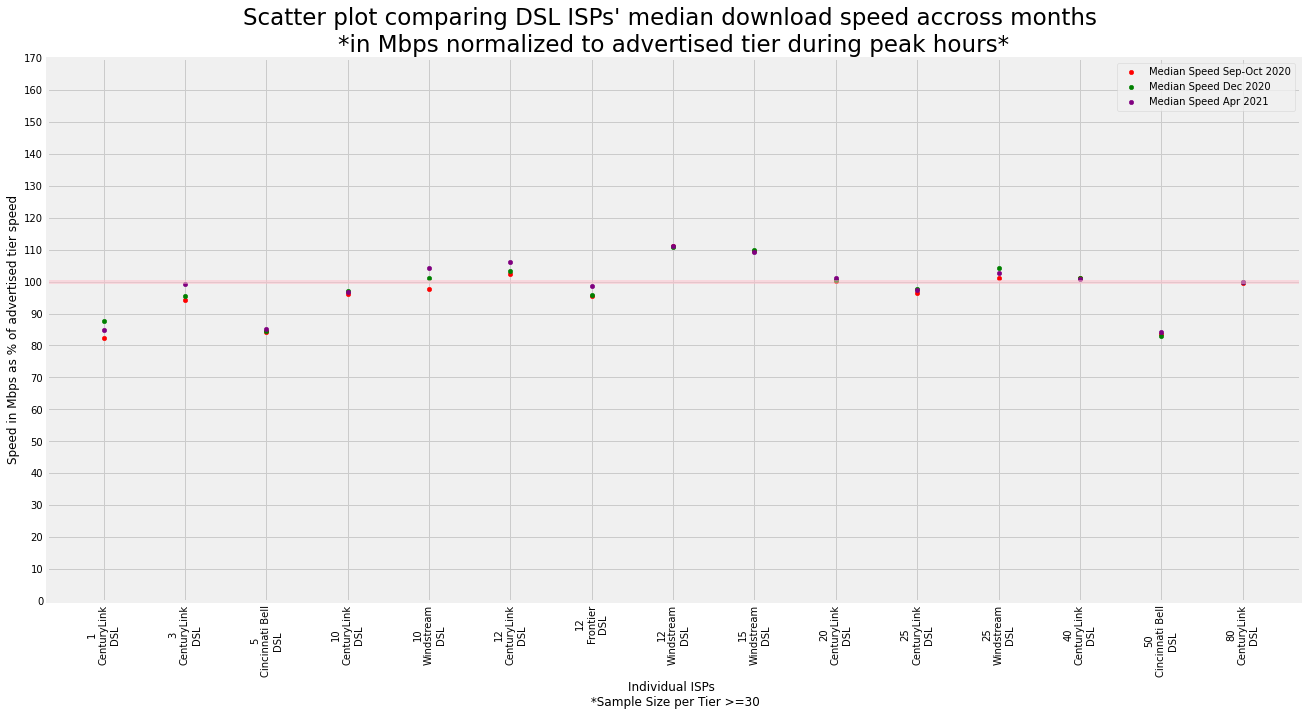

In [30]:
chartDF = finalDF.where(finalDF.tech =='DSL').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='median_x', color='r', label = 'Median Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='median_y', color='g',label = 'Median Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='median', color='purple', label = 'Median Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing DSL ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Cable ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

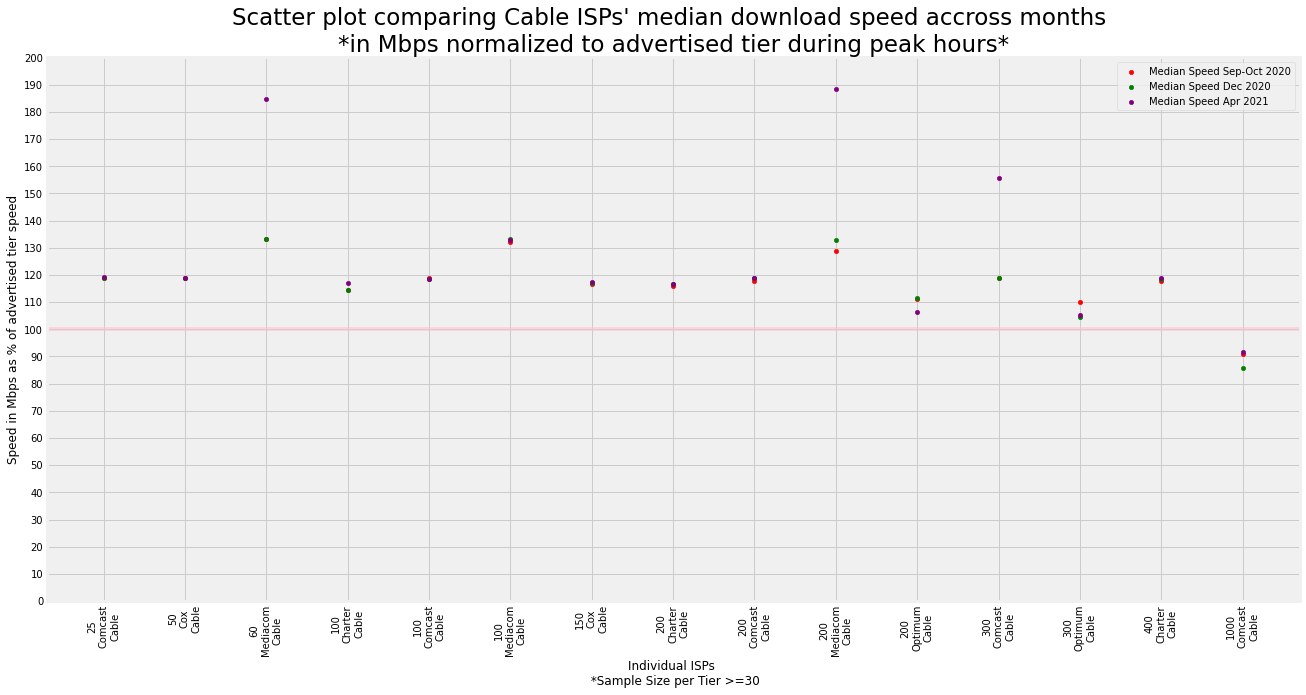

In [34]:
chartDF = finalDF.where(finalDF.tech =='Cable').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='median_x', color='r', label = 'Median Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='median_y', color='g',label = 'Median Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='median', color='purple', label = 'Median Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 210, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Cable ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Fiber ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

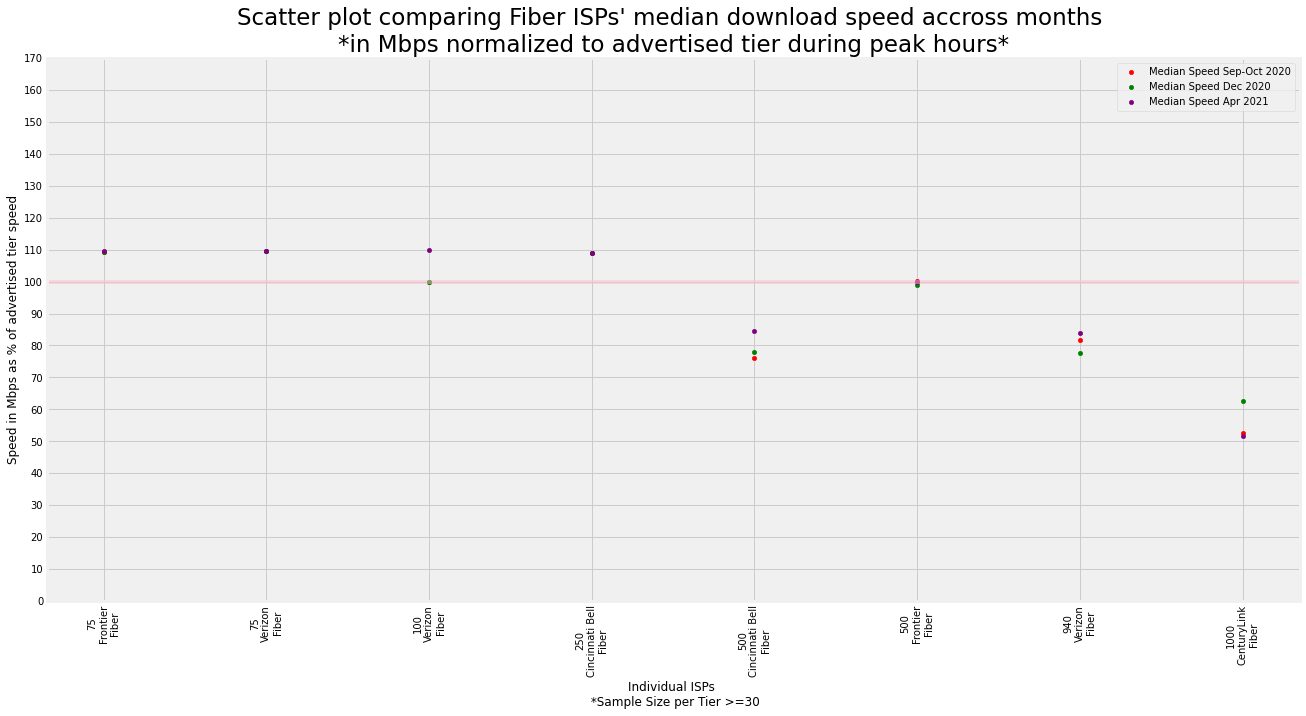

In [35]:
chartDF = finalDF.where(finalDF.tech =='Fiber').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='median_x', color='r', label = 'Median Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='median_y', color='g',label = 'Median Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='median', color='purple', label = 'Median Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Fiber ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing DSL ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

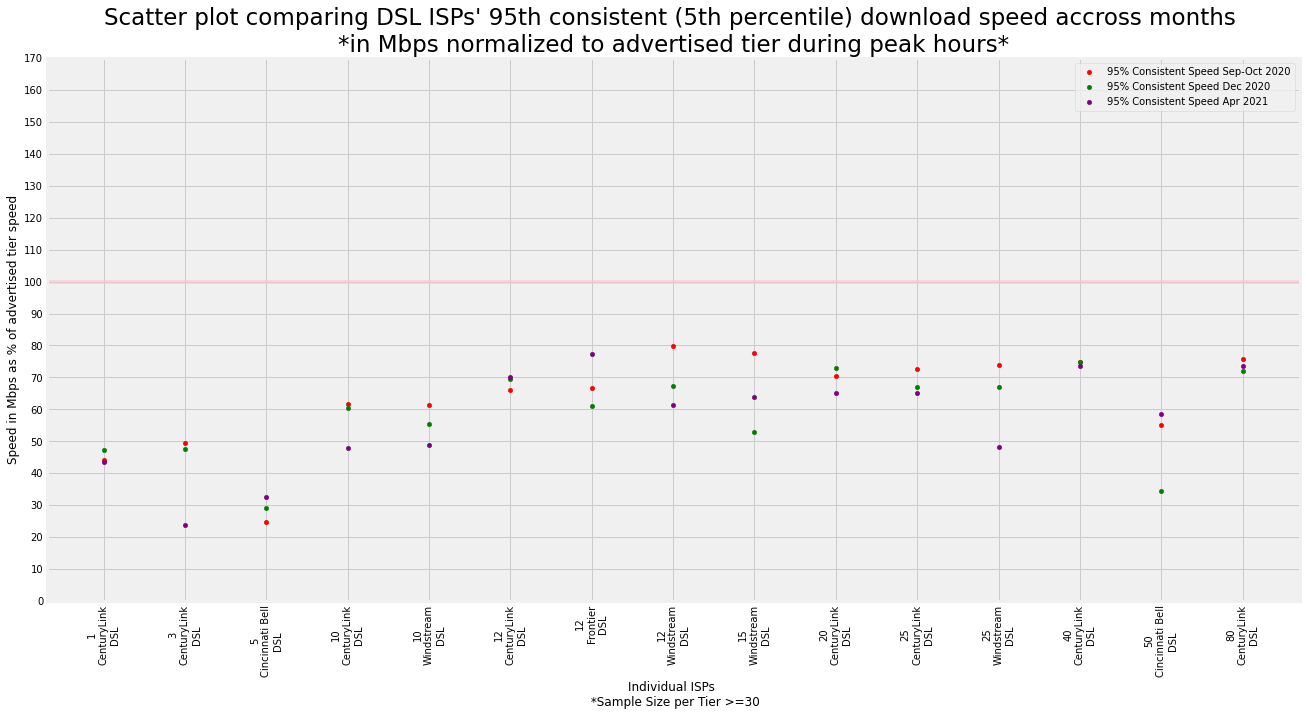

In [36]:
chartDF = finalDF.where(finalDF.tech =='DSL').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='fivepct_x', color='r', label = '95% Consistent Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='fivepct_y', color='g',label = '95% Consistent Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='fivepct', color='purple', label = '95% Consistent Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing DSL ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Cable ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

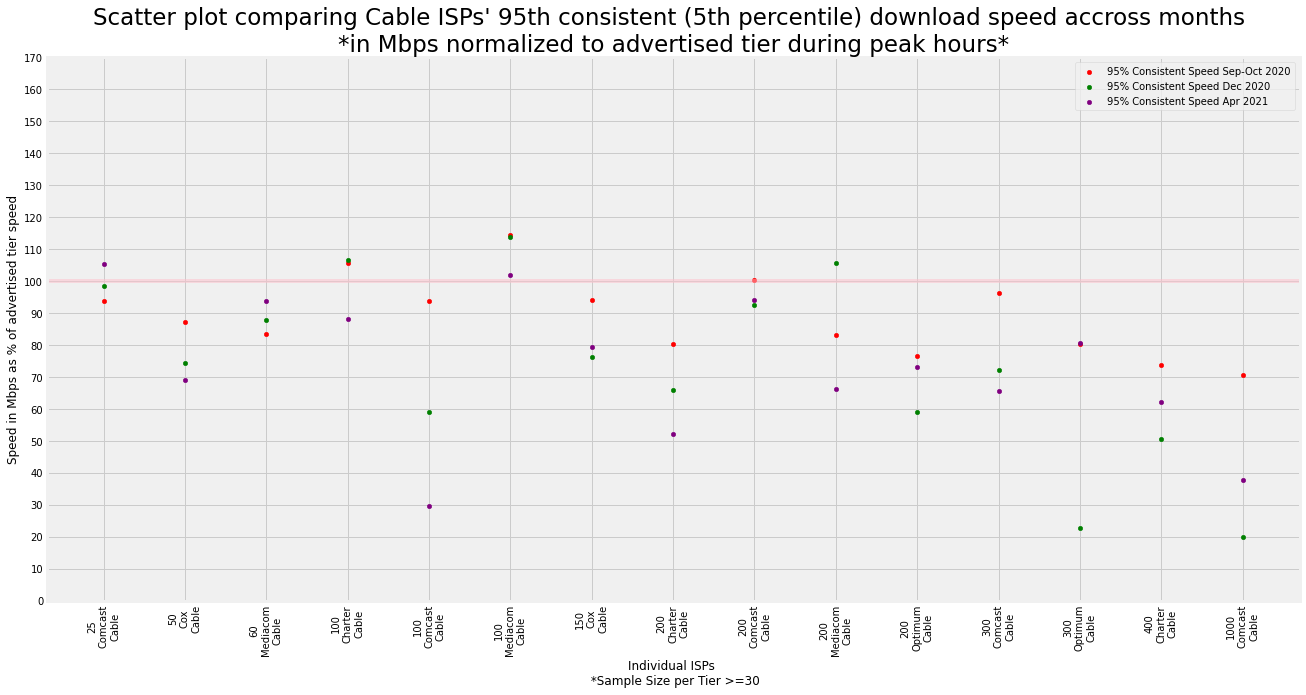

In [38]:
chartDF = finalDF.where(finalDF.tech =='Cable').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='fivepct_x', color='r', label = '95% Consistent Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='fivepct_y', color='g',label = '95% Consistent Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='fivepct', color='purple', label = '95% Consistent Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Cable ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Fiber ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

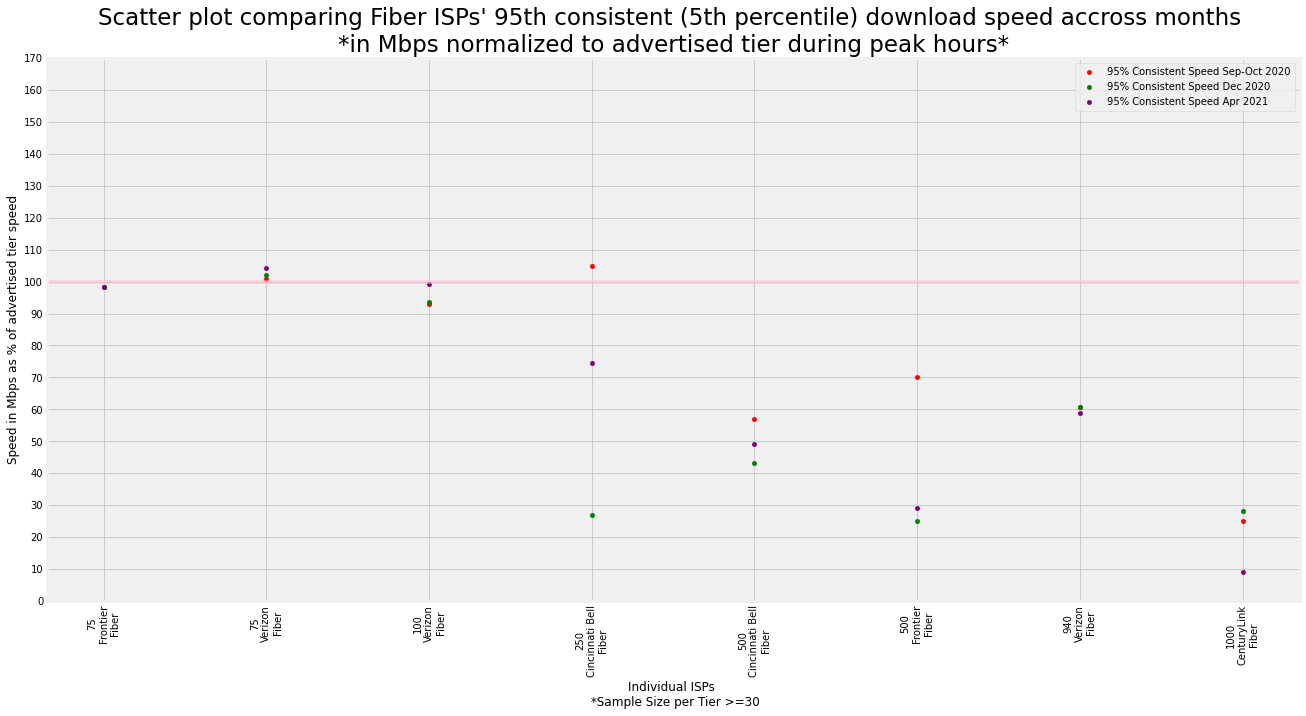

In [39]:
chartDF = finalDF.where(finalDF.tech =='Fiber').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='fivepct_x', color='r', label = '95% Consistent Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='fivepct_y', color='g',label = '95% Consistent Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='fivepct', color='purple', label = '95% Consistent Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Fiber ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)
